In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Matplotlib retina
%config InlineBackend.figure_format = 'retina'


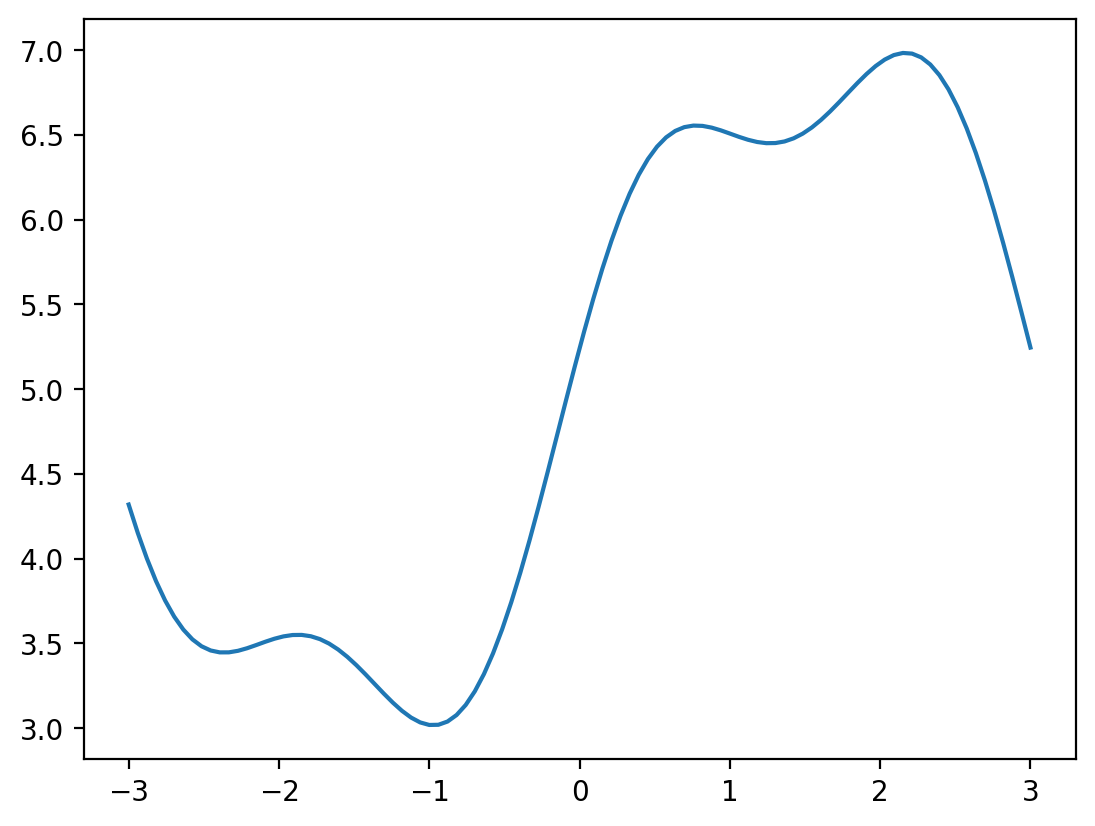

In [214]:
x_lin  = torch.linspace(-3, 3, 100).reshape(-1, 1)
f = lambda x: 2*torch.sin(x) + torch.sin(2*x**(1.1) + 1) + 0.3*x + 10
f = lambda x: 2*torch.sin(x) + 0.5*torch.sin(3*x + 0.5) + 5



plt.plot(x_lin, f(x_lin), label='f(x)')

In [215]:
def phi(x, degree=2):
    # Polynomial features
    return torch.cat([x**i for i in range(0, degree+1)], dim=1)

In [316]:
class BLR:
    def __init__(self, mu, sigma, sigma_noise, degree=2):
        self.current_mean = mu
        self.current_sigma = sigma
        self.sigma_noise = sigma_noise  # Add sigma_noise as an instance variable
        self.is_prior_set = True
        self.N = 0
        self.X_total = None
        self.y_total = None
        self.degree = degree
    
    def __repr__(self):
        return f'BLR(mu={self.current_mean},\n sigma={self.current_sigma}, \nsigma_noise={self.sigma_noise})'

    def update(self, X, y):
        """
        X: (n_points, n_features)
        y: (n_points, 1)
        """
        
        if not self.is_prior_set:
            raise Exception('Prior not set')
        n_points = X.shape[0]
        X_orig = X
        X = phi(X, self.degree)
        print(X.shape, X_orig.shape)
        self.current_sigma_inverse = torch.inverse(self.current_sigma)
        XTX = torch.matmul(X.T, X)
        SN_inverse = self.current_sigma_inverse + XTX / self.sigma_noise**2
        SN = torch.inverse(SN_inverse)

        self.current_mean = torch.matmul(SN, torch.matmul(self.current_sigma_inverse, self.current_mean) + torch.matmul(X.T, y).ravel() / self.sigma_noise**2)
        self.current_sigma = SN
        self.N += n_points
        if self.X_total is None:
            self.X_total = X_orig
            self.y_total = y
        else:
            self.X_total = torch.cat((self.X_total, X_orig), 0)
            self.y_total = torch.cat((self.y_total, y), 0)

    def predict(self, X):
        if not self.is_prior_set:
            raise Exception('Prior not set')
        
        X_orig = X
        X = phi(X, self.degree)
        
        # Calculate the predictive mean and variance
        predictive_mean = torch.matmul(X, self.current_mean)
        predictive_variance = 1 / self.sigma_noise**2 + torch.diag(torch.matmul(X @ self.current_sigma, X.T))
        
        return predictive_mean, predictive_variance

    def plot_predictive(self, X):
    
        X_orig = X
        X = phi(X, self.degree)
        
        # Posterior distribution
        posterior_mean = torch.matmul(X, self.current_mean)
        posterior_variance = 1 / self.sigma_noise**2 + torch.diag(torch.matmul(X @ self.current_sigma, X.T))
        
        plt.figure(figsize=(10, 6))
        plt.title("Posterior Distribution")
            
        plt.fill_between(X_orig.ravel().numpy(), (posterior_mean - 2 * posterior_variance).numpy(), (posterior_mean + 2 * posterior_variance).numpy(), color='r', alpha=0.2, label='Posterior')
            
        plt.plot(X_orig.ravel().numpy(), posterior_mean.numpy(), 'r-', label='Posterior Mean')
        
        if self.X_total is not None:
            plt.scatter(self.X_total.numpy(), self.y_total.numpy(), c='purple', marker='*', label='Observed Data', s=200)
        
        plt.legend()
        return plt.gca()



In [317]:
d = 2
phi_x = phi(x_lin, degree=d)

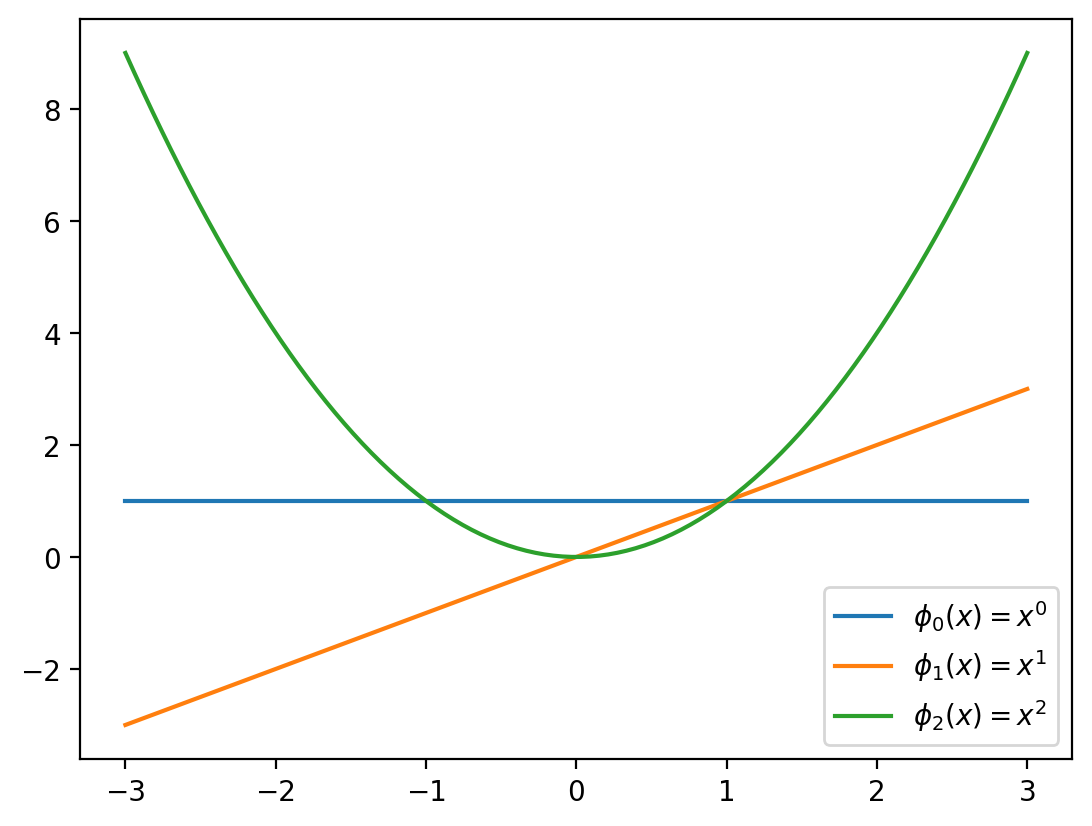

In [318]:
for i in range(d+1):
    plt.plot(x_lin, phi_x[:, i], label=r'$\phi_{}(x) = x^{}$'.format(i, i))
plt.legend()

In [356]:
def init_prior(d):
    prior_mu = torch.zeros(d+1)  # Adjust for your dimensionality
    prior_sigma = torch.eye(d+1)  # Adjust for your dimensionality
    sigma_noise = 2  # Adjust for your noise level
    return prior_mu, prior_sigma, sigma_noise

def init_prior_params(d):
    prior_params = init_prior(d)
    return prior_params + (d, )

In [357]:
init_prior_params(d)

(tensor([0., 0., 0., 0.]),
 tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]),
 2,
 3)

In [358]:
d = 1
blr = BLR(*init_prior_params(d))

In [359]:
blr

BLR(mu=tensor([0., 0.]),
 sigma=tensor([[1., 0.],
        [0., 1.]]), 
sigma_noise=2)

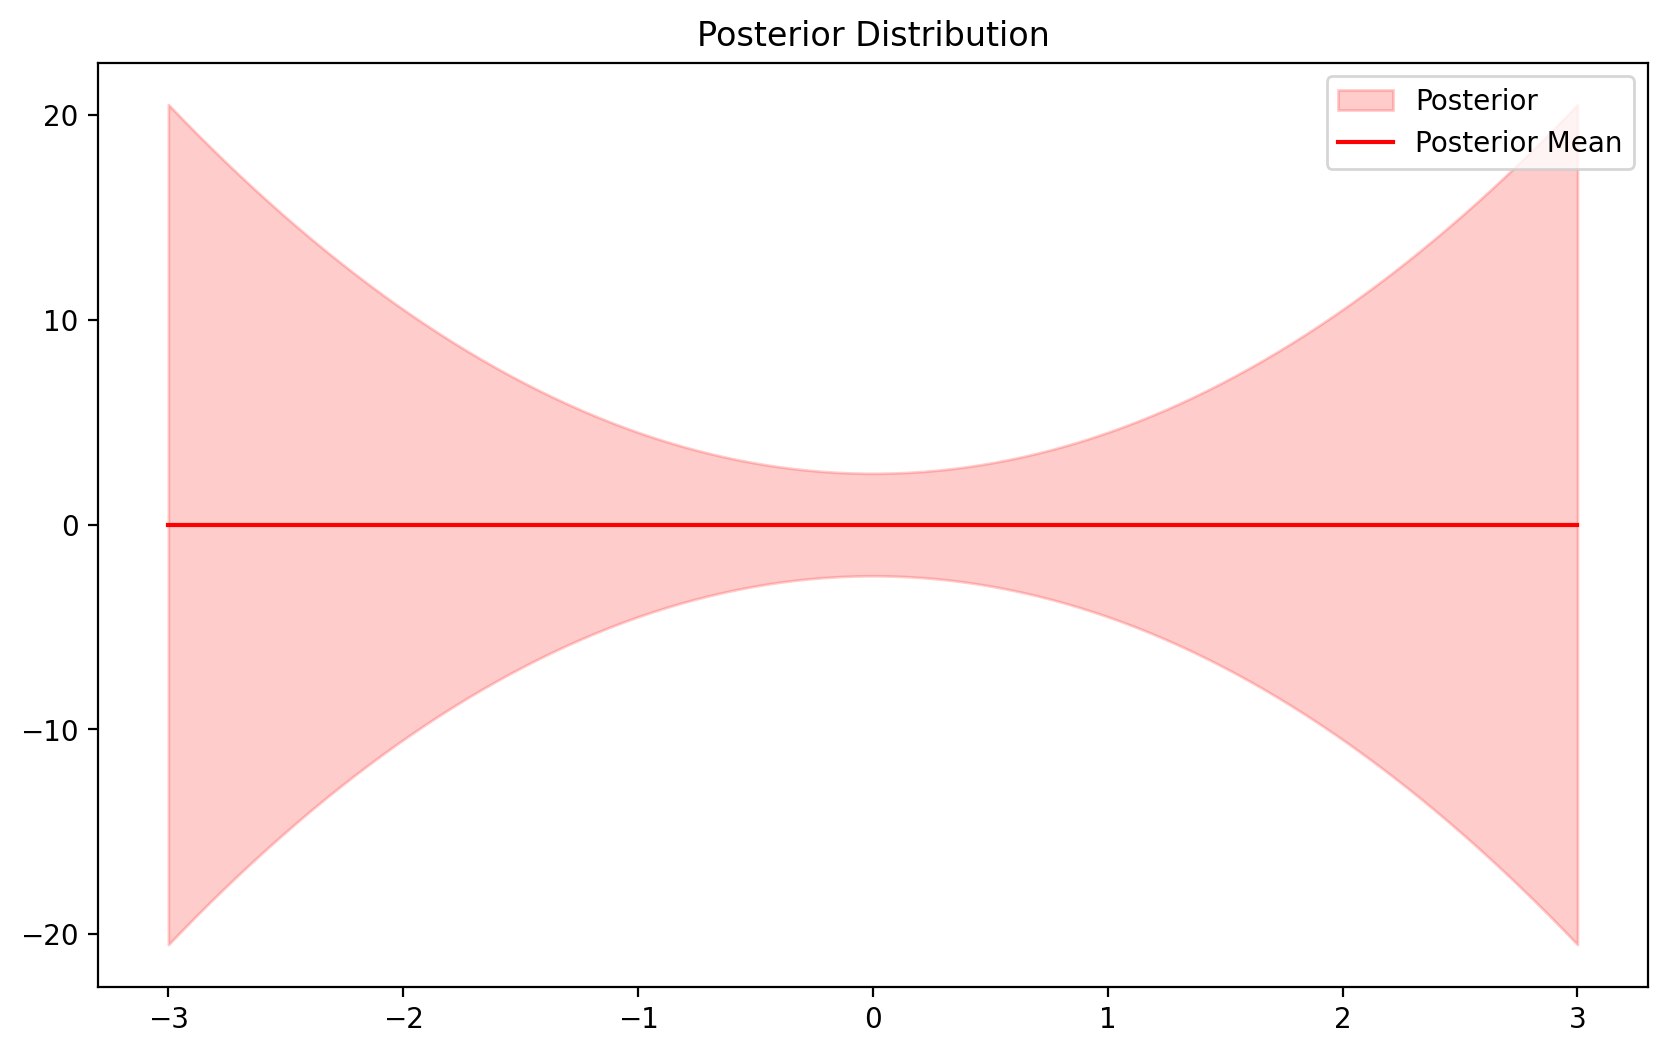

In [360]:
ax= blr.plot_predictive(x_lin)

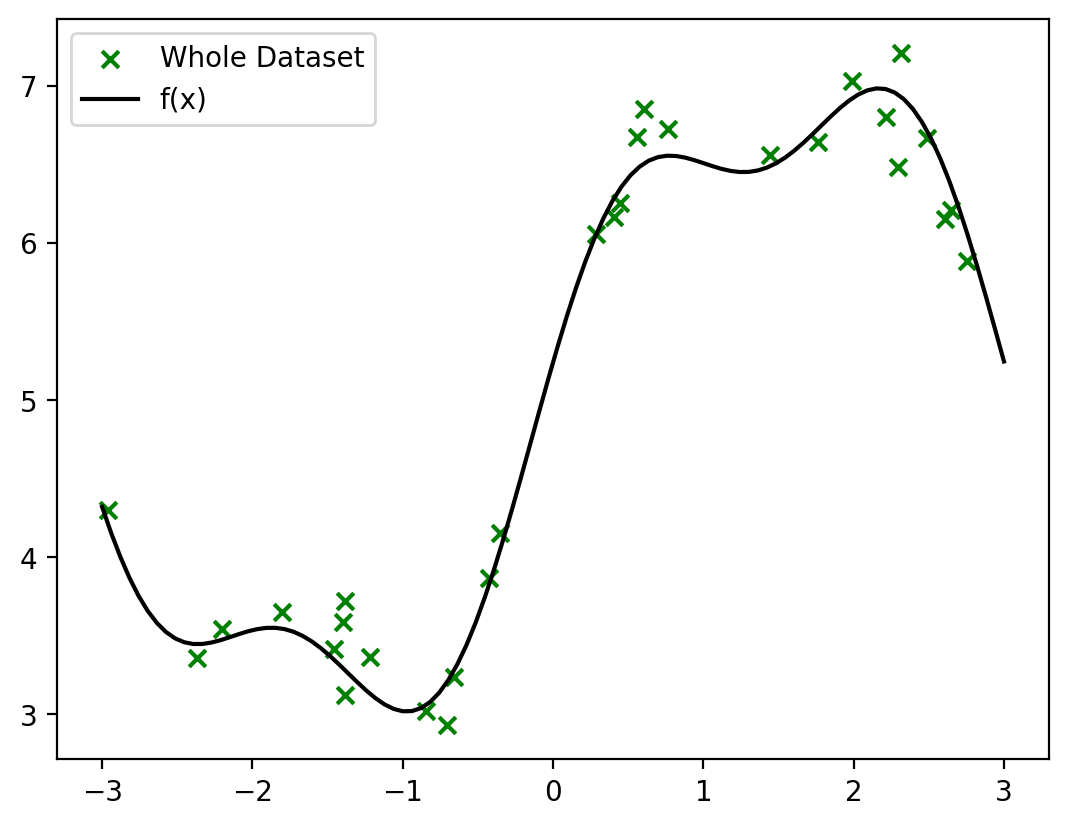

In [361]:
torch.manual_seed(42)
N_TOT = 30
X_dataset = torch.distributions.Uniform(-3, 3).sample((N_TOT, 1))
f_dataset = f(X_dataset)
y_dataset = f_dataset + torch.distributions.Normal(0, 0.2).sample((N_TOT, 1))

def plot_dataset(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Plot the dataset
    ax.scatter(X_dataset.numpy(), y_dataset.numpy(), c='g', marker='x', label='Whole Dataset')
    ax.plot(x_lin, f(x_lin), label='f(x)',c = 'k')
    ax.legend()
    
plot_dataset()

In [362]:
# Add the first 1 data points to the model
d = 2
blr = BLR(*init_prior_params(d))
blr.update(X_dataset[:1], y_dataset[:1])

torch.Size([1, 3]) torch.Size([1, 1])


In [363]:
blr

BLR(mu=tensor([0.1709, 0.3919, 0.8988]),
 sigma=tensor([[ 0.9736, -0.0605, -0.1387],
        [-0.0605,  0.8613, -0.3181],
        [-0.1387, -0.3181,  0.2705]]), 
sigma_noise=2)

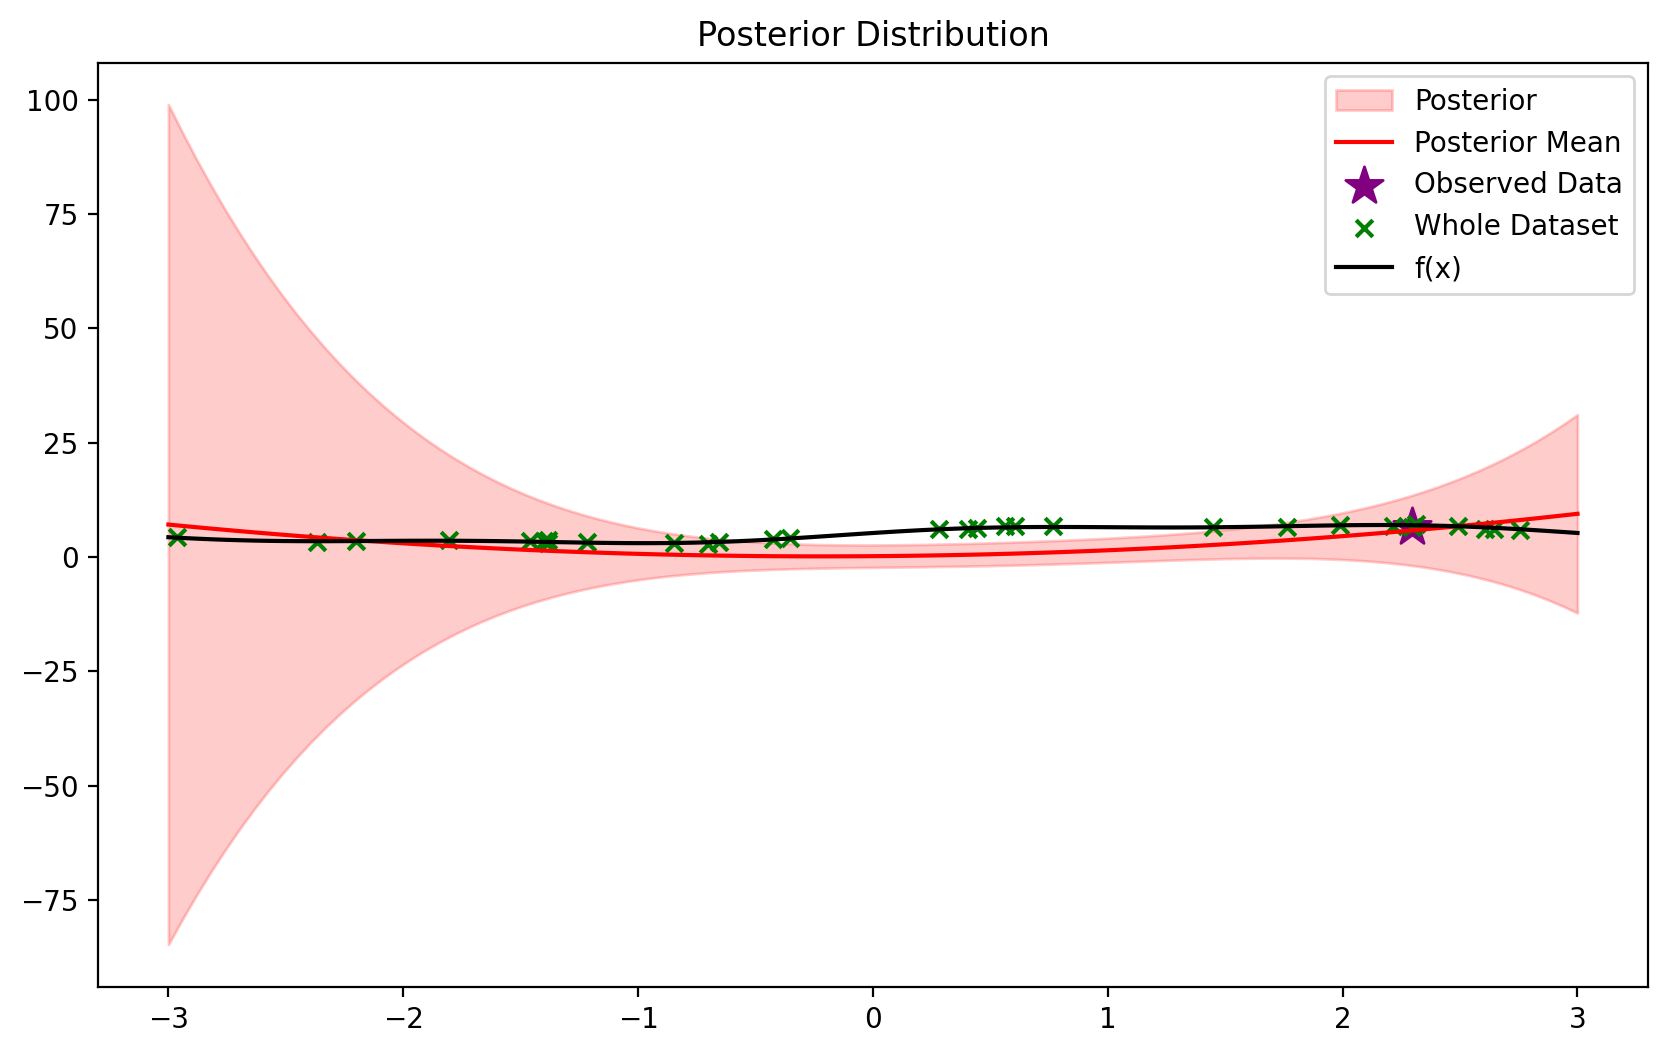

In [364]:
ax = blr.plot_predictive(x_lin)
plot_dataset(ax=ax)

In [365]:
# Add the next 1 data points to the model
blr.update(X_dataset[1:2], y_dataset[1:2])

torch.Size([1, 3]) torch.Size([1, 1])


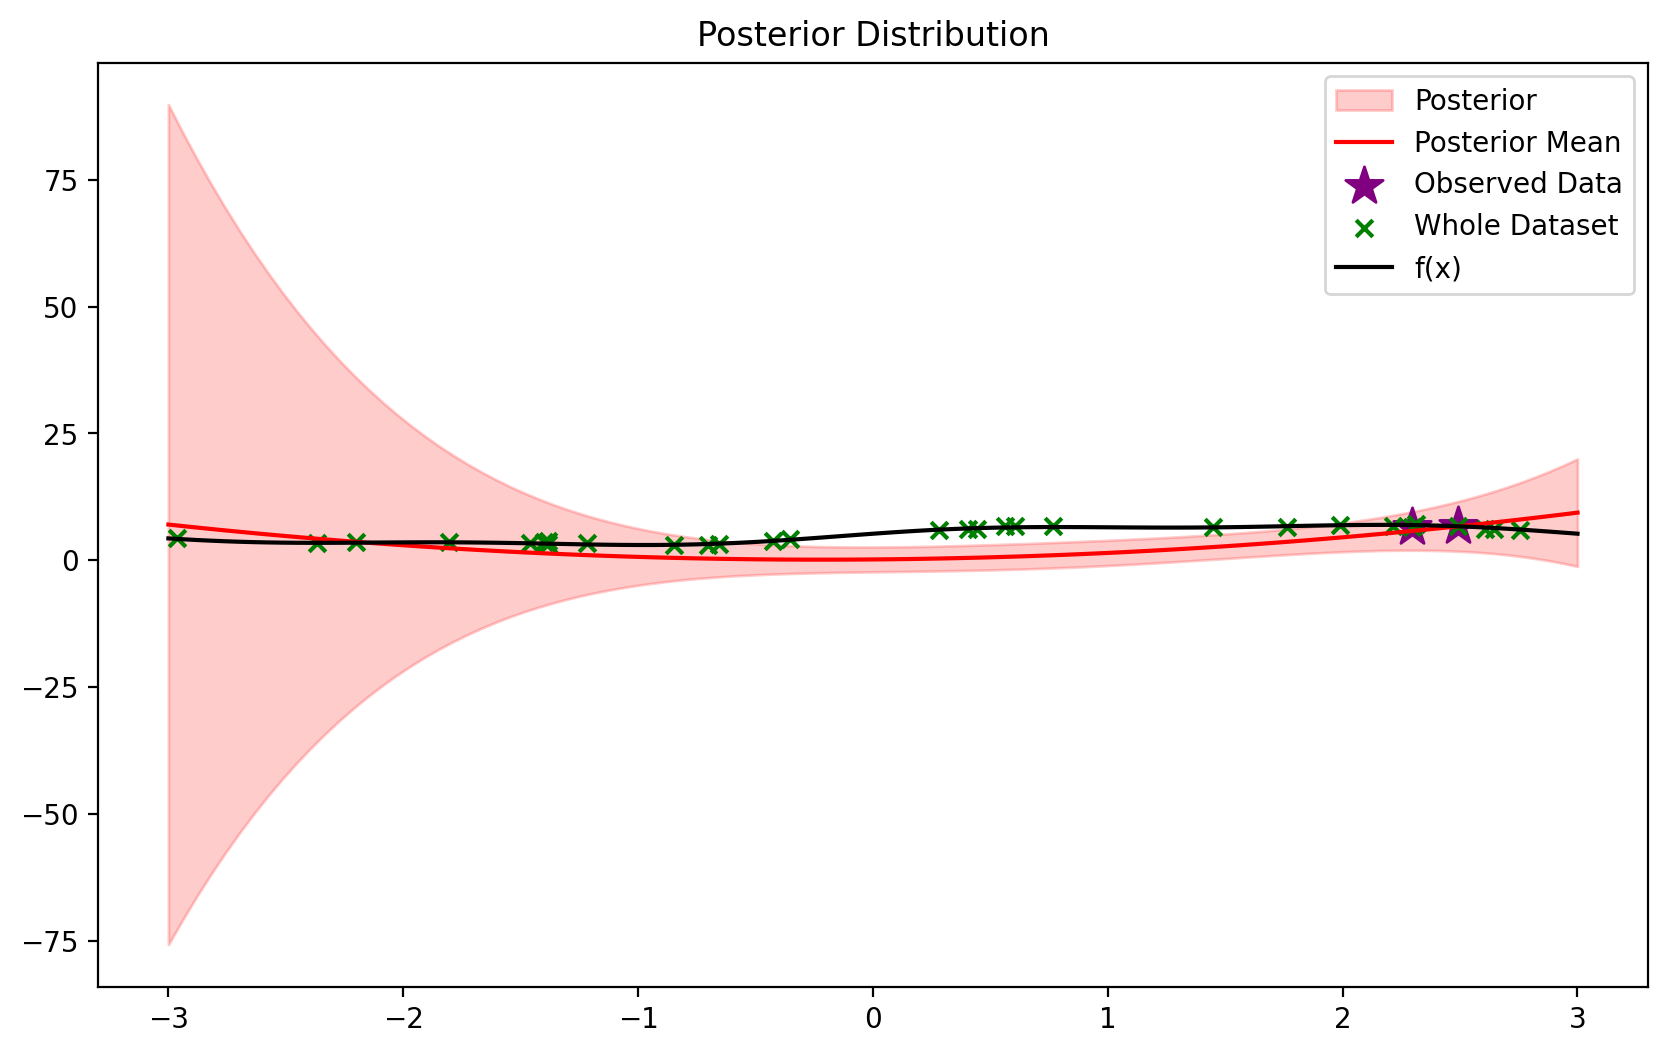

In [366]:
ax = blr.plot_predictive(x_lin)
plot_dataset(ax=ax)

In [367]:
blr

BLR(mu=tensor([0.1711, 0.3912, 0.8943]),
 sigma=tensor([[ 0.9735, -0.0600, -0.1356],
        [-0.0600,  0.8599, -0.3275],
        [-0.1356, -0.3275,  0.2077]]), 
sigma_noise=2)

In [368]:
# instead, add the two data points at once
d = 2
blr_new = BLR(*init_prior(d))
blr_new.update(X_dataset[:2], y_dataset[:2])

torch.Size([2, 3]) torch.Size([2, 1])


In [369]:
blr

BLR(mu=tensor([0.1711, 0.3912, 0.8943]),
 sigma=tensor([[ 0.9735, -0.0600, -0.1356],
        [-0.0600,  0.8599, -0.3275],
        [-0.1356, -0.3275,  0.2077]]), 
sigma_noise=2)

In [370]:
blr_new

BLR(mu=tensor([0.1711, 0.3912, 0.8943]),
 sigma=tensor([[ 0.9735, -0.0600, -0.1356],
        [-0.0600,  0.8599, -0.3275],
        [-0.1356, -0.3275,  0.2077]]), 
sigma_noise=2)

<AxesSubplot:title={'center':'Posterior Distribution'}>

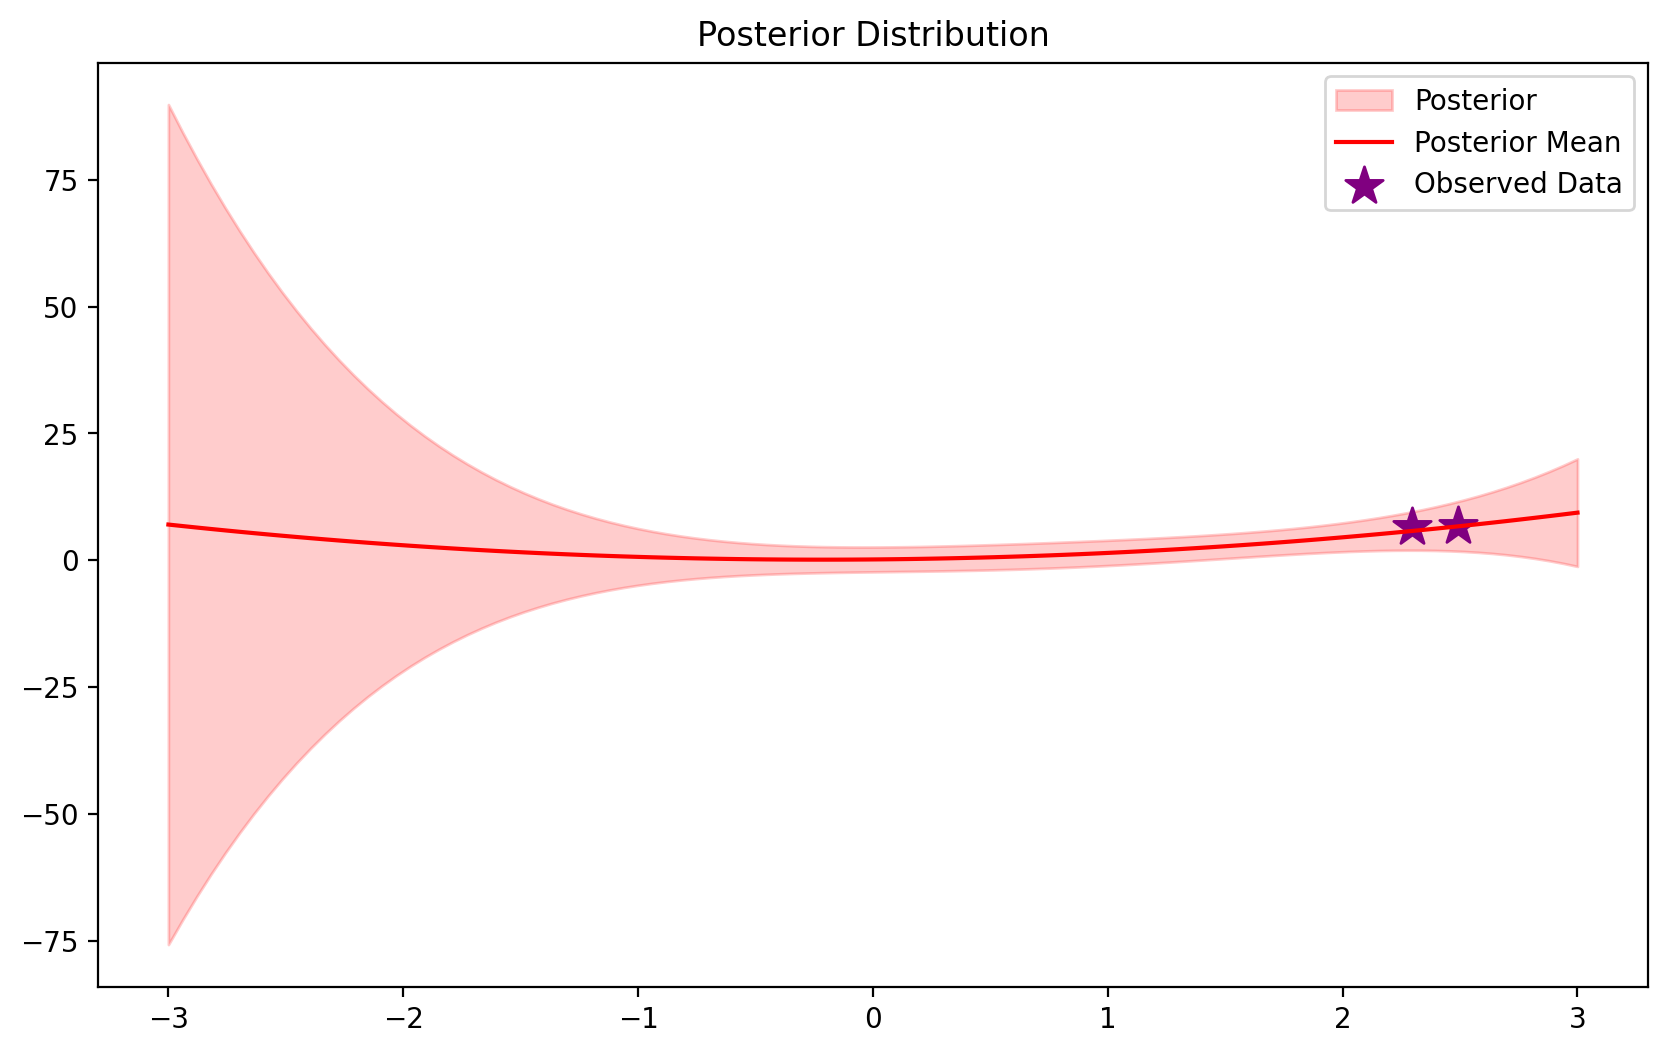

In [371]:
blr_new.plot_predictive(x_lin)

torch.Size([30, 2]) torch.Size([30, 1])


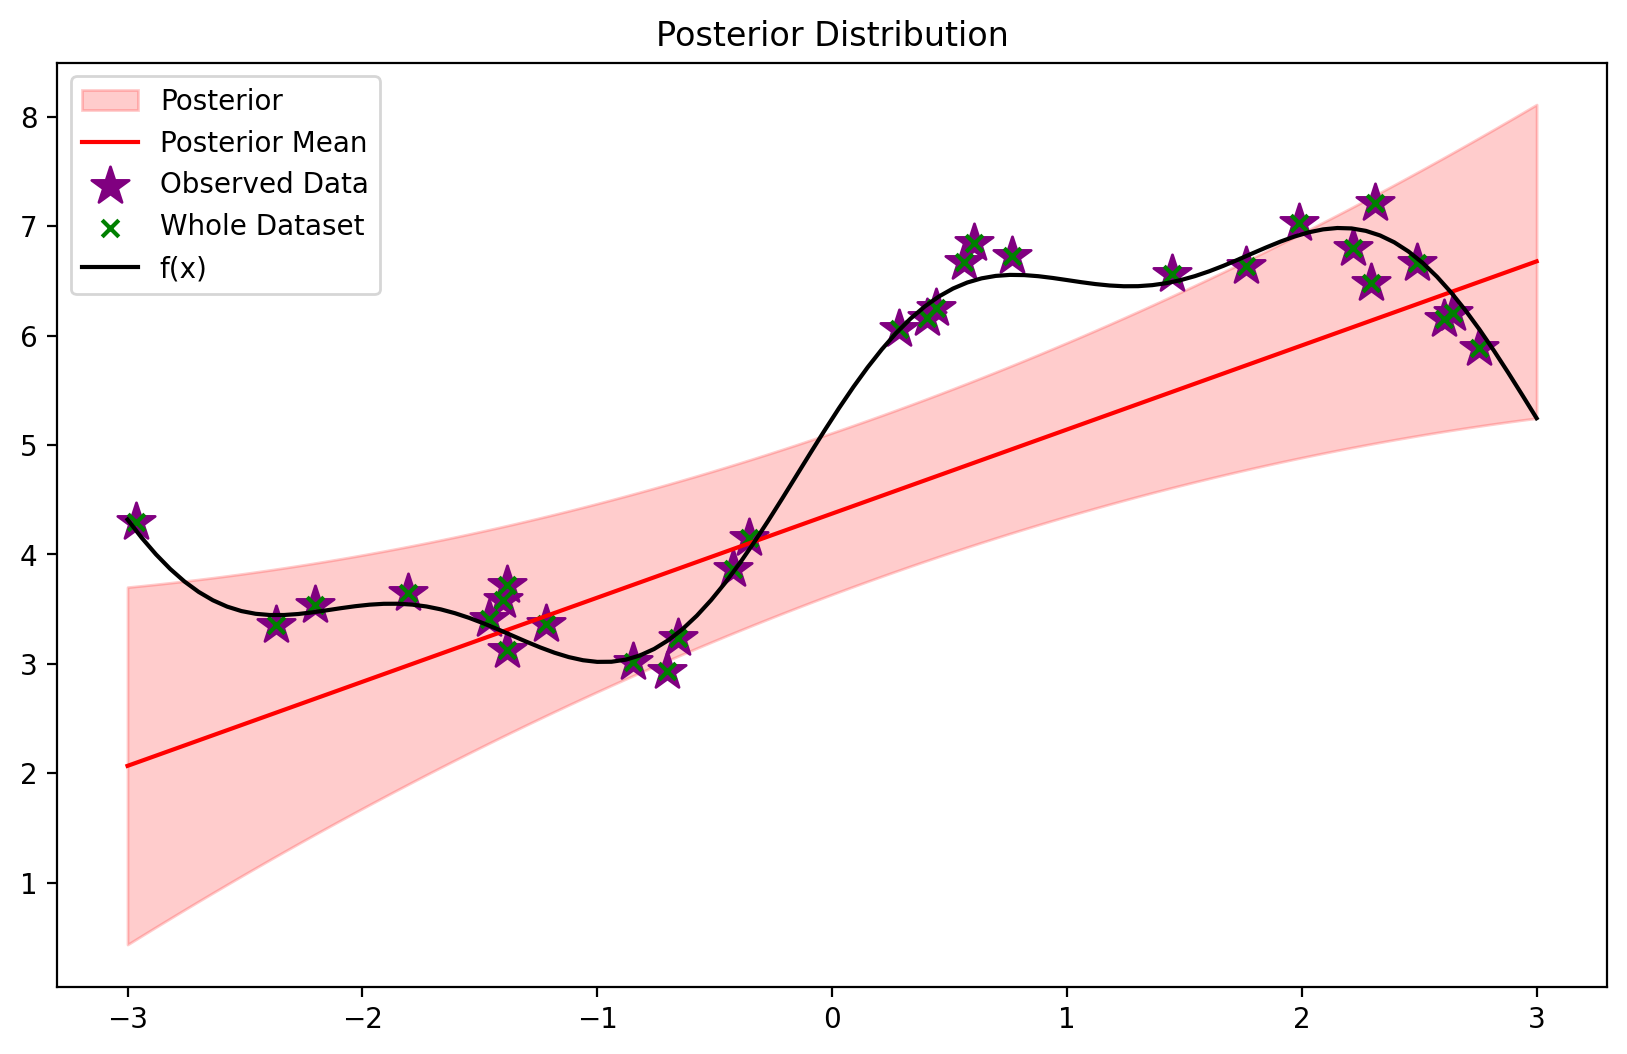

In [372]:
# Entire dataset
d = 1
blr = BLR(*init_prior_params(d))
blr.update(X_dataset, y_dataset)
ax = blr.plot_predictive(x_lin)
plot_dataset(ax=ax)

torch.Size([30, 4]) torch.Size([30, 1])


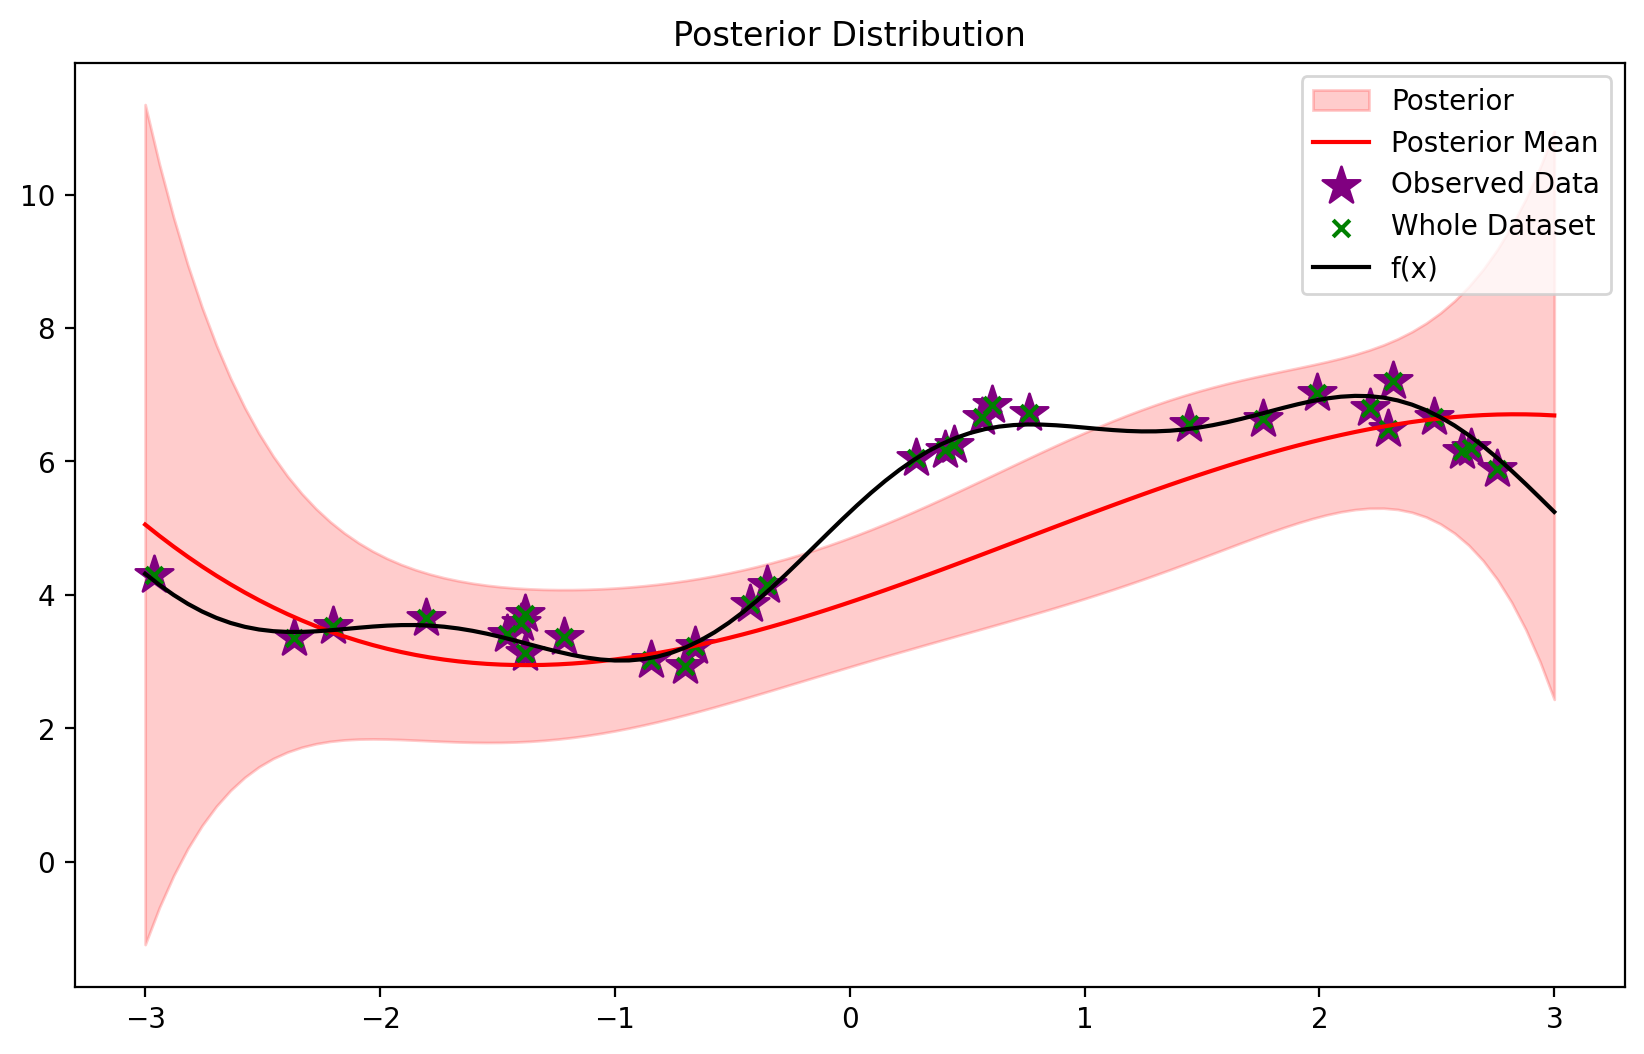

In [375]:
# Entire dataset
d = 3
blr = BLR(*init_prior_params(d))
blr.update(X_dataset, y_dataset)
ax = blr.plot_predictive(x_lin)
plot_dataset(ax=ax)
